In [3]:
import glob
import os.path
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os, shutil, pathlib, fnmatch
import scipy.ndimage as ndimage
from tempfile import TemporaryFile
import plotly.express as px
%matplotlib inline

#Создаем вложенные папки для сортировки файлов

def CreateFolder():
    try:
        #Делаем проверку на их наличие
        if not os.path.isdir("png") or not os.path.isdir("ox") or not os.path.isdir("plot") or not os.path.isdir("npy"):
            os.mkdir("png")
            os.mkdir("ox")
            os.mkdir("npy")
    except: pass

#Вычисляем среднее значение кровотока мышки
def mean_bloodflow(file):
    
    #индекс кровотока - это обратная величина той, что записана в файлах
    #формат данных в файлах - Float 32

    bloodflow_index = 1/np.fromfile(file, dtype=np.float32)
    
    #поскольку в результате у вас получается одномерный массив, его лучше собрать в массив продолжительность съёмкиx512x512
    bloodflow_index = bloodflow_index.reshape(int(bloodflow_index.shape[0]/512/512),512,512)
    
    #далее файл можно сгладить гауссовым фильтром
    bloodflow_index_smooth = ndimage.gaussian_filter(bloodflow_index, sigma=(1, 3, 3), order=0)
    
    #далее вы в отдельной переменной считаете среднюю картинку на образец
    mean_bloodflow_index_smooth = bloodflow_index_smooth.mean(axis=0)
    
    return mean_bloodflow_index_smooth

#Выделяем выделенную область в виде одномерного массива
def bloodflowCut(file):
    
    #Проделываем аналогичные операции, за исключением усреднения
    bloodflow_index = 1/np.fromfile(file, dtype=np.float32)
    
    bloodflow_index = bloodflow_index.reshape(int(bloodflow_index.shape[0]/512/512),512,512)
    
    bloodflow_index_smooth = ndimage.gaussian_filter(bloodflow_index, sigma=(1, 3, 3), order=0)
    
    # заданием формат среза
    xsize = 200 
    ysize = 200
    # задаем координаты
    x0 = 180
    y0 = 150
        
    return bloodflow_index_smooth[:,x0:x0+xsize,y0:y0+ysize]

def plotdef(mean_bloodflow, file, file_loc):
    
    #размер области по осям X и Y
    xsize=200
    ysize=200
    
    #начальные координаты. координаты (0,0) лужат в ВЕРХНЕМ левом углу
    x0 = 180
    y0 = 150
    
    plt.figure(figsize=(6,6)) # размер изображения в дюймах
    plt.imshow(mean_bloodflow,extent=(0,512,512,0)) #рисуем среднюю картинку

    plt.colorbar(shrink=0.8,label = 'Bloodflow index') #рисуем рядом шкалу псевдоцвета
    plt.title(file)
    plt.axis('off') #отрубаем подписи осей 

    #если промазали по органу - именяем вначале координаты x0 и y0, пока не попадем 
    plt.axhspan(ymin=y0,ymax=y0+ysize,xmin=x0/512,xmax=(x0+xsize)/512,color='#ffffff55')
        
    os.chdir(file_loc)
    
    plt.savefig(file[:-4] + '.png' ,dpi=300,bbox_inches='tight')
    plt.show()

# на всякий случай деф для удаления png и npy файлов
def delete_files(Path):
    for Foldername in os.listdir(Path):
        file_destination_png_def = str(Path + '/' + Foldername + "/" + 'png' + '/')
        file_destination_npy_def = str(Path + '/' + Foldername + "/" + 'npy' + '/')
        
        #немного спагетти-кода
        for i in os.listdir(file_destination_png_def):
            os.remove(file_destination_png_def+ i)
        for j in os.listdir(file_destination_npy_def):
            os.remove(file_destination_npy_def+ j)

def CreateAndWriteNpyData(Data, file_location, file):
    
    #направляемся в папку
    os.chdir(file_location)
    
    #создаем и записываем, сохраняем файл с расширением .npy
    np.save(file_location + '/' + file[:-4] + '.npy', Data)

In [4]:
# Указываем корневой путь
Path = str('C:\Documents\DataforPracticise')
 
for Foldername in os.listdir(Path):

    #собираем путь
    local_path = str (Path + '\\' + Foldername)
    
    #перемещаемся в локальную папку
    os.chdir(local_path)
    
    #Создаем папки для сортировки
    CreateFolder()
    
    file_destination1 = str(local_path + "\\" + 'ox')
    file_destination2 = str(local_path + "\\" + 'plot')
    
    #root - все содержащиеся атрибуты dirs - каталоги вложенных папок files - имеющиеся файлы
    for root, dirs, files in os.walk(local_path):
        # цикл перебора файлов из каталога файлов
        for fileName in files:
            try:
                #сортируем файлы для обработки по папкам
                if ("ox" in fileName):
                    # это нам пока что не нужно
                    shutil.move(local_path + "\\" + fileName, file_destination1)
                if  (fileName.endswith(".txt")):
                    # это нам пока что не нужно
                    shutil.move(local_path + "\\" + fileName, file_destination2)
            except: pass  
    
    #Перемещаемся в корневую папку, чтобы выйти из цикла
        os.chdir(Path)

#Проверяем, в каком каталоге находимся     
os.getcwd()

'C:\\Documents\\DataforPracticise'

In [3]:
#delete_files(Path)
#os.getcwd()

In [65]:
#Получаем сами папки
for Foldername in os.listdir(Path):
    
    #Проходимся по атрибутам папок
    for file in (os.listdir(Foldername)):
        
        if (".dat" in file):  
            
            # Собираем относительный путь каждого файда
            FL = Path + r'/' + str(Foldername) + r'/' + str(file)
            
            # Собираем путь, куда будем перемещать обработанные png файлы
            file_destination3 = str(Path + '\\' + Foldername + "\\" + 'png')
        
            #Собираем путь, куда будем перемещать обработанные npy данные выделенной области образца
            file_destination4 = str(Path + '\\' + Foldername + "\\" + 'npy')
            try:
                pass
                
                #Рисуем и автоматически сохраняем в папку file_destination3 относительно 
                #plotdef(mean_bloodflow(FL), file, file_destination3)
                
                #Создание и запись срезов данных в npy формат в папки (относительные пути)
                #CreateAndWriteNpyData(bloodflowCut(FL).flatten(), file_destination4, file)
                
            except: pass 
            os.chdir(Path)
            
df_main = []
name_file = []

# Цикл для добавления для создания картежа и массивов образцов
for Foldername in os.listdir(Path):
    #print(Foldername)
    
    folderN1 = Path + '\\' + Foldername + '\\' + 'png' 
    #print(folderN1)
    
    for folder_local in os.listdir(Foldername):
        if ("npy" in folder_local):
            
            folderN = Path + '\\' + Foldername + '\\' + folder_local
            #print(folderN)
            
            for file in os.listdir(folderN):
                
                x = folderN + '\\' + file       
                read_file =  np.load(x)
                #print(read_file)
                df_main.append(read_file)
                #print(df_main)
                if ("npy" in file):
                     name_file.append(file)
        os.chdir(Path)

#получаем информацию о полученной переменной
row=len(df_main)
column=len(df_main[0])
print(f'Rows:{row}, Column:{column}')
print("Shape of a list:",len(df_main))

Rows:17, Column:2880000
Shape of a list: 17


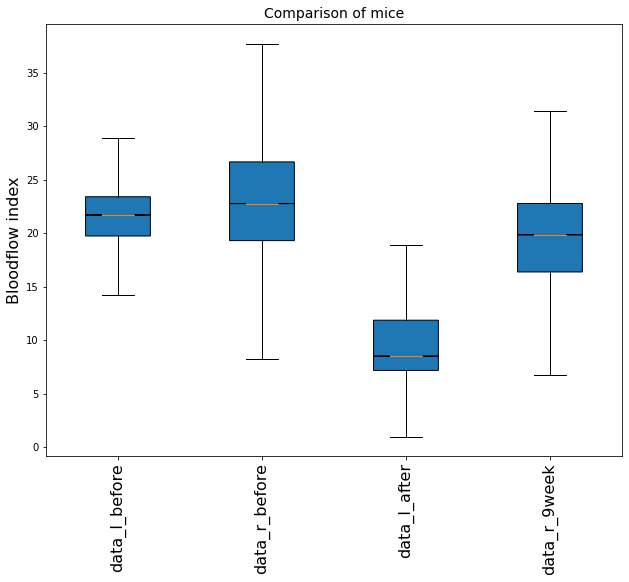

In [80]:
#Спагетти код в студию!
#i1 new 2 l before.npy
df_1f = df_main[1]
df_1n = name_file[1]
#i1 new 2 r before.npy
df_3f = df_main[3]
df_3n = name_file[3]
#1 new 2 l after
df_0f = df_main[0]
df_0n = name_file[0]
#1 new r 8 week
df_2f = df_main[2]
df_2n = name_file[2]
#######################

#i2  l before.npy
df_5f = df_main[5]
df_5n = name_file[5]
#i2  r before.npy
df_8f = df_main[8]
df_8n = name_file[8]
#2  l after
df_4f = df_main[4]
df_4n = name_file[4]
#2  9 week
df_7f = df_main[7]
df_7n = name_file[7]
#######################

#i5 l before.npy
df_10f = df_main[10]
df_10n = name_file[10]
#i5 r before.npy
df_12f = df_main[12]
df_12n = name_file[12]
#5 l after
df_9f = df_main[9]
df_9n = name_file[9]
#5 r 9 week
df_11f = df_main[11]
df_11n = name_file[11]
#######################

#m4 l before.npy
df_14f = df_main[14]
df_14n = name_file[14]
#m4 r before.npy
df_16f = df_main[16]
df_16n = name_file[16]
#m4 l after
df_13f = df_main[13]
df_13n = name_file[13]
#m4 r 9 week
df_15f = df_main[15]
df_15n = name_file[15]

#[df_1n, df_3n, df_0n, df_2n]
data_i1 = [df_1f, df_3f, df_0f, df_2f]
#[df_5n, df_8n, df_4n, df_7n]
data_i2 = [df_5f, df_8f, df_4f, df_7f]
#[df_10n, df_12n, df_9n, df_11n]
data_i5 = [df_10f, df_12f, df_9f, df_11f]
#[df_14n, df_16n, df_13n, df_15n]
data_m4 = [df_14f, df_16f, df_13f, df_15f]

#[df_1n, df_5n, df_10n, df_14n]
data_l_before = [df_1f, df_5f, df_10f, df_14f]

#[df_3n, df_8n, df_12n, df_16n]
data_r_before = [df_3f, df_8f, df_12f, df_16f]

#[df_0n, df_4n, df_9n, df_13n]
data_l_after = [df_0f, df_4f, df_9f,df_13f]

#[df_2n, df_7n, df_11n, df_15n]
data_r_9week = [df_2f, df_7f, df_11f, df_15f]

#[df_1n, df_5n, df_10n, df_14n, df_3n, df_8n, df_12n, df_16n, df_0n, df_4n, df_9n, df_13n, df_2n, df_7n, df_11n, df_15n]
data_before_main = [df_1f, df_5f, df_10f, df_14f, df_3f, df_8f, df_12f, df_16f, df_0f, df_4f, df_9f,df_13f, 
                   df_2f, df_7f, df_11f, df_15f]

flat_list_before_l = []
for xs in data_l_before:
    for x in xs:
        flat_list_before_l.append(x)

flat_list_before_r = []
for xs in data_r_before:
    for x in xs:
        flat_list_before_r.append(x)

flat_list_l_after = []
for xs in data_l_after:
    for x in xs:
        flat_list_l_after.append(x)

flat_list_r_9week = []
for xs in data_r_9week:
    for x in xs:
        flat_list_r_9week.append(x)

xxx = [flat_list_before_l, flat_list_before_r, flat_list_l_after, flat_list_r_9week]

fig = plt.figure(figsize = (8, 6))

ax = fig.add_axes([0, 0, 1, 1])
 
bp = ax.boxplot(xxx, patch_artist = True, notch ='True', vert = 1, showmeans = False, showfliers = False)

ax.set_xticklabels(['data_l_before', 'data_r_before', 'data_l_after', 'data_r_9week'], fontsize = 16, rotation = 'vertical')
plt.title('Comparison of mice', fontsize = 14)
plt.ylabel('Bloodflow index', fontsize = 16)
plt.savefig('Comparison of mice', dpi = 300, bbox_inches = 'tight')

plt.show()